In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar as cal
from collections import OrderedDict

%matplotlib inline
sns.set()
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Cleaning the Data

- We create labels and ranges for age groups
- Remove any data points with ages less than 0 (not possible) and drop all duplicates that has the patient appearing mulitple times on the same day (can be an error or actual scheduling on the same day, remove all just to be sure).


In [2]:
bins = [0, 3, 13, 20, 40, 60, np.inf]
labels = ['toddler', 'childhood', 'teenager', 'adulthood', 'middle age', 'elder']

data = (pd.read_csv('noshowappointments-kagglev2-may-2016.csv', encoding='utf8', dtype={'PatientId': object, 'AppointmentID': object})
            .query("Age >= 0")
            .drop_duplicates(subset=['PatientId', 'AppointmentDay'], keep=False)
            .assign(ScheduledDay=lambda x: pd.to_datetime(pd.to_datetime(x['ScheduledDay']).dt.date),
                    AppointmentDay=lambda x: pd.to_datetime(x['AppointmentDay']),
                    age_group=lambda x: pd.cut(x['Age'], bins, labels=labels, include_lowest=True),
                    yes=lambda x: (x['No-show'] == 'Yes').astype(int),
                    no=lambda x: (x['No-show'] == 'No').astype(int)))

def noshow_counts(df, columns):
    df = df.copy()
    return df.groupby(columns)['No-show'].value_counts().unstack(1).reset_index()

def get_noshow_ratio(df):
    return df['Yes']/(df['No']+df['Yes'])

def get_percentage(data, columns):
    rows = []
    for column in columns:
        filtered = data[column] != 1
        row = OrderedDict()
        row['Category'] = column
        row['No'] = data[filtered]['no'].sum()
        row['Yes'] = data[filtered]['yes'].sum()
        row['Total'] = row['Yes'] + row['No']
        row['Perc'] = row['No'] / float(row['Total'])
        rows.append(row)
    return pd.DataFrame(rows, columns=rows[0].keys())

def get_levels(df, column):
    levels = df[column].unique()
    rows = []
    for i in levels:
        row = OrderedDict()
        row['level'] = i
        row['no'] = df[df[column] == i]['no'].sum()
        row['yes'] = df[df[column] == i]['yes'].sum()
        row['total'] = float(row['no']+row['yes'])
        row['no_pct'] = row['no']/row['total']
        row['yes_pct'] = row['yes']/row['total']
        rows.append(row)
        
    new_df = pd.DataFrame(rows, columns=row.keys())
    
    if column in df.select_dtypes(include=['category']):
        new_df['level'] = new_df['level'].astype('category')
        new_df['level'].cat.reorder_categories(df[column].cat.categories, inplace=True)
        
    return new_df

def graph(df, column, x='level', y='no_pct'):
    
    new_df = get_levels(df, column)
    sns.barplot(x=x, y=y, data=new_df)
    sns.plt.title('Percentage of {} by Level'.format(column))
    sns.plt.ylabel('Percentage')

#no_cats_matched = data[data[cats].apply(lambda x: min(x) == max(x), 1)]
cats = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']

data['no_cat'] = data[cats].apply(lambda x: min(x) == max(x), 1)
data['day'] = data['AppointmentDay'].apply(lambda x: cal.day_name[x.weekday()]).astype('category')
data['day'].cat.reorder_categories(list(cal.day_name)[:6], inplace=True)
data.age_group.cat.reorder_categories(labels, ordered=True, inplace=True)
cats.append('no_cat')

data['day'].cat.reorder_categories(list(cal.day_name)[:6], inplace=True)
data['age_group'].cat.reorder_categories(labels, ordered=True, inplace=True)

In [3]:
(data['days_between'] / pd.Timedelta(days=1)).hist()

KeyError: 'days_between'

## Changes to the Data Read

- Change PatientId and AppointId to object types (they were coming in as integers and made queryies awkward)
- Make a query for ages greater than or equal to 0 (some entries had ages of -1, and I wasn't sure what that exactly spoke to)
- Drop duplicates of PatientId and AppointmentDay. (Mutiple entires for the patient on the same day)
- Create/Changed several columns:
    - ScheduledDay => Changed type to date_time
    - age_group => Added an age group category that categorizes segments of ages
    - Yes => An explicit yes on attendance
    - No => An explicit no on attendance

In [ ]:
data.info()

## Breakdown by Category

I performed a simple calculation to see what are the percentage of people who came in under one of the categories did not come in. Patients who exhibited Hyptertension came in the most times for their appointments, while peopel who received SMS's did not. However, the percentages are still close, and don't seem to show any patterns that can show the likelihood of a patient appearing.

Some other things to look at regarding categories:
- Percentage of patients that came in who didn't fit any categories
- Percentage of patients who came in with multiple categories
- Show a bar or pie chart breaking down how much of each category is represented as a percentage of no shows.

In [4]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,age_group,yes,no,no_cat,day
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,childhood,0,1,True,Friday
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,middle age,0,1,False,Friday
5,95985133231274,5626772,F,2016-04-27,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,No,elder,0,1,False,Friday
6,733688164476661,5630279,F,2016-04-27,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0,Yes,adulthood,1,0,True,Friday
7,3449833394123,5630575,F,2016-04-27,2016-04-29,39,GOIABEIRAS,0,0,0,0,0,0,Yes,adulthood,1,0,True,Friday


In [5]:
no_shows = data[data['no'] == 1].copy()

In [6]:
no_shows

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,age_group,yes,no,no_cat,day
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,childhood,0,1,True,Friday
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,middle age,0,1,False,Friday
5,95985133231274,5626772,F,2016-04-27,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,No,elder,0,1,False,Friday
8,56394729949972,5638447,F,2016-04-29,2016-04-29,21,ANDORINHAS,0,0,0,0,0,0,No,adulthood,0,1,True,Friday
9,78124564369297,5629123,F,2016-04-27,2016-04-29,19,CONQUISTA,0,0,0,0,0,0,No,teenager,0,1,True,Friday
10,734536231958495,5630213,F,2016-04-27,2016-04-29,30,NOVA PALESTINA,0,0,0,0,0,0,No,adulthood,0,1,True,Friday
12,566654781423437,5634718,F,2016-04-28,2016-04-29,22,NOVA PALESTINA,1,0,0,0,0,0,No,adulthood,0,1,False,Friday
13,911394617215919,5636249,M,2016-04-28,2016-04-29,28,NOVA PALESTINA,0,0,0,0,0,0,No,adulthood,0,1,True,Friday
14,99884723334928,5633951,F,2016-04-28,2016-04-29,54,NOVA PALESTINA,0,0,0,0,0,0,No,middle age,0,1,True,Friday
15,99948393975,5620206,F,2016-04-26,2016-04-29,15,NOVA PALESTINA,0,0,0,0,0,1,No,teenager,0,1,False,Friday


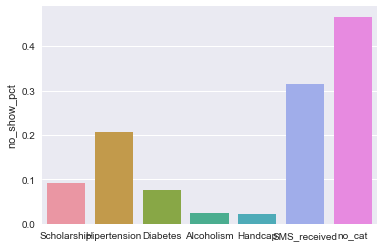

In [7]:
no_shows_graph = (no_shows[cats].sum() / len(no_shows)).to_frame(name='no_show_pct')
sns.barplot(x=no_shows_graph.index, y=no_shows_graph['no_show_pct'], data=no_shows_graph)

AttributeError: module 'seaborn' has no attribute 'plt'

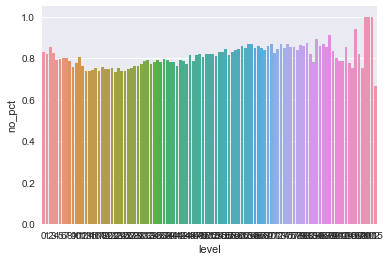

In [8]:
graph(data, 'Age')

In [ ]:
get_levels(data, 'Hipertension')

In [9]:
get_levels(data, 'age_group')

,level,no,yes,total,no_pct,yes_pct
0,childhood,8855,2450,11305.00,0.78,0.22
1,middle age,20703,4731,25434.00,0.81,0.19
2,elder,14659,2520,17179.00,0.85,0.15
3,adulthood,18606,5599,24205.00,0.77,0.23
4,teenager,6107,2082,8189.00,0.75,0.25
5,toddler,6650,1364,8014.00,0.83,0.17


In [10]:
get_levels(data, 'day')

,level,no,yes,total,no_pct,yes_pct
0,Friday,12606,3347,15953.00,0.79,0.21
1,Tuesday,17761,4272,22033.00,0.81,0.19
2,Monday,15323,4004,19327.00,0.79,0.21
3,Wednesday,17783,4267,22050.00,0.81,0.19
4,Thursday,12078,2848,14926.00,0.81,0.19
5,Saturday,29,8,37.00,0.78,0.22


In [16]:
perc = get_percentage(data, ['age_group'])
g = sns.FacetGrid(perc, 'no_pct')


KeyError: 'no_pct'

In [ ]:
data['age_group'].value_counts().plot.bar()

In [ ]:
age_groups = data.groupby('age_group')
age_groups['Alcoholism'].sum()

In [ ]:
data[['PatientId', 'AppointmentDay']].duplicated()

## Things to do

1. Column DataType Changes
    - PatientId = Object (or a ID type if pandas has that)
    - Scholarship = Category
    - Hipertension = Category
    - Diabetes = Category
    - Alcoholism = Category
    - Handicap = Category
    - SMS_received = Category
    - No_Shows = Category
    
2. Remove outliers
    - a -1.00 age needs to be removed. 0 age may refer to babies, so that may stay the same.
    
3. Visualizations
    - Bar chart of major categories (Scholarship, Hipertension, Diabetes, Alcoholism, and Handcap)

In [ ]:
data.info()

In [ ]:
major_cats_alt = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
major_cats_alt_no_show = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']
no_shows = data[data['No-show'] == 'Yes']
no_shows.mean(numeric_only=True)

In [ ]:
shows = data[data['No-show'] == 'No']
shows.std(numeric_only=True)

In [ ]:
age_comparison = data[['Age', 'No-show']]
age_comparison.info()

In [ ]:
bins = [0, 1, 4, 9, 13, 18, 35, 55, np.inf]
labels = ['baby', 'toddler', 'gradeschool', 'preteen', 'teenager', 'youngadult', 'middle-aged', 'elder']
data['age_groups'] = pd.cut(data['Age'], bins, labels=labels, include_lowest=True)

age_comparison = (data.pipe(noshow_counts, ['age_groups'])
                      .set_index('age_groups')
                      .fillna(0)
                      .assign(noshow_ratio=get_noshow_ratio))

age_comparison.plot.bar()
age_comparison

In [ ]:
data[major_cats_alt_no_show].groupby('No-show').sum().T.plot.bar()

In [ ]:
data[major_cats_alt_no_show].groupby('No-show').sum()

In [ ]:
data[major_cats_alt].filter?

In [ ]:
data[major_cats_alt].filter

In [ ]:
no_select = data.copy()
no_select['No-selection'] = data.filter(major_cats_alt).eq(0).all(1)
no_select

In [ ]:
selections = data.copy()
selections['Selections'] = data[major_cats_alt].sum(axis=1)
selections = selections.groupby('Selections')['No-show'].value_counts().unstack(1)
selections.apply(lambda x: x/selections.sum().sum())

In [ ]:
data['PatientId'].value_counts().max()

In [ ]:
patient_counts = data.copy()
patient_counts['freq'] = data.groupby('PatientId')['PatientId'].transform('count')
patient_counts = patient_counts.groupby('freq')['No-show'].value_counts().unstack(1).reset_index().fillna(0)
patient_counts['Patients'] = patient_counts.apply(lambda x: (x['No']+x['Yes'])/x['freq'], axis=1)
patient_counts['% of Missed'] = patient_counts['Yes']/(patient_counts['No']+patient_counts['Yes'])
patient_counts.plot.scatter(x='freq', y='% of Missed', marker='o', c='b')

In [ ]:
sns.lmplot(x='freq', y='% of Missed', data=patient_counts)

In [ ]:
gender = data.groupby('Gender')['No-show'].value_counts().unstack(1)
gender

In [ ]:
neighbourhoods = data.groupby('Neighbourhood')['No-show'].value_counts().unstack(1)
neighbourhoods['% of Missed'] = neighbourhoods['Yes']/(neighbourhoods['No']+neighbourhoods['Yes'])
neighbourhoods['total'] = neighbourhoods.iloc[:, :2].sum(axis=1)
neighbourhoods.sort_values('% of Missed', ascending=False)

In [ ]:
data.info()

In [ ]:
test = data.copy()
test['ScheduledDay'] = pd.to_datetime(pd.to_datetime(test['ScheduledDay']).dt.date)
test['AppointmentDay'] = pd.to_datetime(test['AppointmentDay'])
test['days_left'] = test['AppointmentDay'] - test['ScheduledDay']
test = test.groupby('days_left')['No-show'].value_counts().unstack(1).fillna(0).reset_index()
test = test.query('days_left >= "0 days"')
q = pd.cut(test.days_left, 15)
new = test.groupby(q).sum()
new['%'] = new['Yes']/(new['No']+new['Yes'])
new

In [ ]:
data.groupby('No-show')['No-show'].transform('value_counts')